# Download Dataset

In [10]:
! kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
! unzip stanford-car-dataset-by-classes-folder.zip -d data
! rm -r stanford-car-dataset-by-classes-folder.zip

--2020-12-05 14:27:02--  https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder/download/archive.zip
Resolving www.kaggle.com... 35.244.233.98
Connecting to www.kaggle.com|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=16&returnUrl=%2Fjutrera%2Fstanford-car-dataset-by-classes-folder%3Fresource%3Ddownload%2Farchive.zip [following]
--2020-12-05 14:27:02--  https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=16&returnUrl=%2Fjutrera%2Fstanford-car-dataset-by-classes-folder%3Fresource%3Ddownload%2Farchive.zip
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘archive.zip’

archive.zip             [ <=>                ]   7.55K  --.-KB/s    in 0s      

2020-12-05 14:27:02 (65.4 MB/s) - ‘archive.zip’ saved [7

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg
import os
import cv2
import copy
import pandas as pd

%matplotlib inline

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla K80


In [2]:
dataset_dir = "data/car_data/car_data/"

In [24]:
input_n = 224

data_transforms = {
    "train": transforms.Compose([transforms.Resize((input_n, input_n)),
                                 #transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor(),
                                ]),
    "test": transforms.Compose([transforms.Resize((input_n, input_n)),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                ])
}


image_datasets = {x: datasets.ImageFolder(root=os.path.join(dataset_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == "train" else False, num_workers=6)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Visualise Dataset

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(22,16))
    plt.imshow(inp)
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

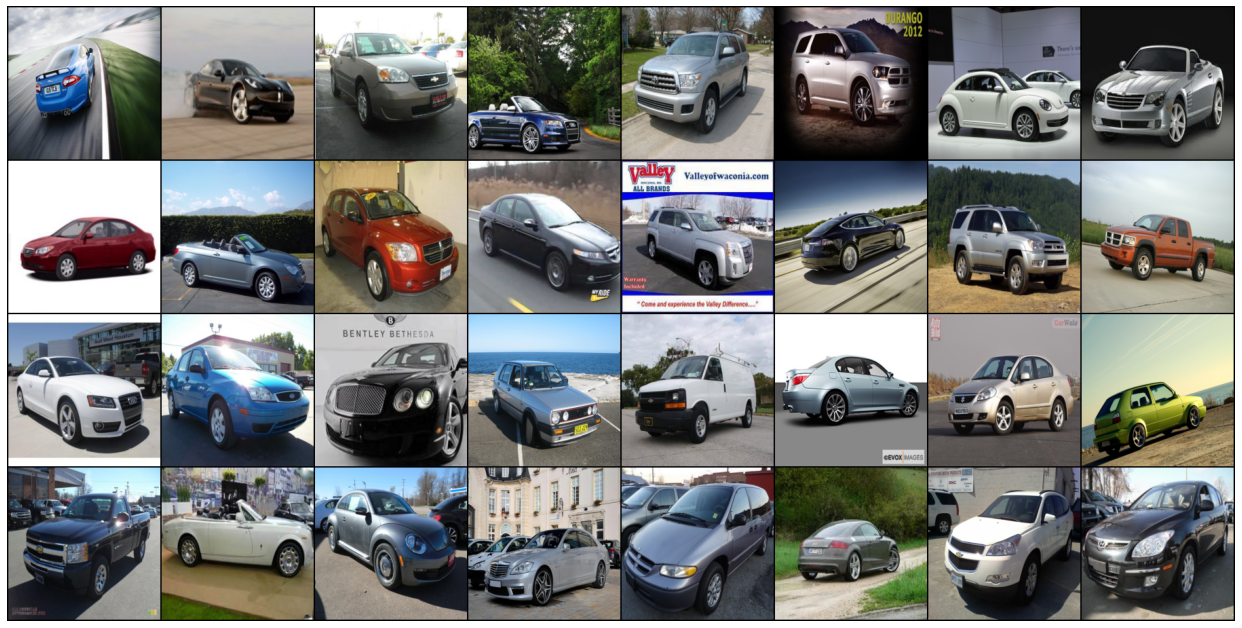

In [26]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train and evalute model

In [27]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    test_losses = []
    
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs-1}')
        print('-' * 10)
        running_loss = 0.0
        running_correct = 0.0
        total = 0.0
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracies.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
        print()
    return model, losses, accuracies, test_losses, test_accuracies

In [28]:
def visual(training_losses, training_accs, test_losses, test_accs, name):

    f, ax = plt.subplots(2,2, figsize = (12, 8))
    ax[0, 0].plot(training_losses)
    ax[0, 0].set_title("Training loss")
    ax[0, 1].plot(training_accs)
    ax[0, 1].set_title("Training acc")
    ax[1, 0].plot(test_losses)
    ax[1, 0].set_title("Test loss")
    ax[1, 1].plot(test_accs)
    ax[1, 1].set_title("Test acc")
    f.suptitle(f'Train visualise {name} 100\'s of batches')
    plt.show()

In [29]:
def training_model_with_visualize(models, names, learning_rate=0.001, n_epochs=4):

    for i in range(len(models)):
        print(f'#### {names[i]}. Baseline ####')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
        lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i],
                                                criterion,
                                                optimizer,
                                                lrscheduler,
                                                n_epochs=n_epochs)

        visual(training_losses,
               training_accs,
               test_losses,
               test_accs,
               f'{names[i]} ({i+1} Conv2D)')

        #Save model
        model_dir = 'saved_models/'
        model_name = f'{names[i]}.pt'
        torch.save(model_ft.state_dict(), model_dir+model_name)

# Define architecture Convolutional Neural Network

In [45]:
class CNN_1_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CP, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear((
            10 * (((n_input - filters + 1) // 2))**2 ), 200)
        
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net1 = CNN_1_CP(input_n, 5)
print(net1)

CNN_1_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=121000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [46]:
class CNN_2_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 20 , 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x
        
net2 = CNN_2_CP(input_n, 5)
print(net2)

CNN_2_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=56180, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [47]:
class CNN_3_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_3_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(20, 30, filters)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net3 = CNN_3_CP(input_n, 5)
print(net3)

CNN_3_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=17280, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [48]:
class CNN_4_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_4_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(15, 25, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(25, 35, filters)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(35, 45, filters)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear( 45 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net4 = CNN_4_CP(input_n, 5)
print(net4)

CNN_4_CP(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(15, 25, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 35, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(35, 45, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


#### CNN_1_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.280985266182112 Acc: 0.004658004412846285
test Loss: 5.275664876483848 Acc: 0.005220633934120571

Epoch 1/6
----------
train Loss: 5.266887317132821 Acc: 0.007477322873253247
test Loss: 5.257873477603872 Acc: 0.008203853325046613

Epoch 2/6
----------
train Loss: 5.224611023530915 Acc: 0.013851434175042901
test Loss: 5.209394501069083 Acc: 0.014418893722809198

Epoch 3/6
----------
train Loss: 5.155356013678429 Acc: 0.02108359892130424
test Loss: 5.195866866671869 Acc: 0.014170292106898694

Epoch 4/6
----------
train Loss: 5.131771374169621 Acc: 0.02537386614366266
test Loss: 5.186552276694308 Acc: 0.016407706650093227

Epoch 5/6
----------
train Loss: 5.110825120599049 Acc: 0.02782544741358176
test Loss: 5.1810894339628435 Acc: 0.016159105034182723

Epoch 6/6
----------
train Loss: 5.087830254189318 Acc: 0.03285118901691591
test Loss: 5.17849743998962 Acc: 0.016532007458048475



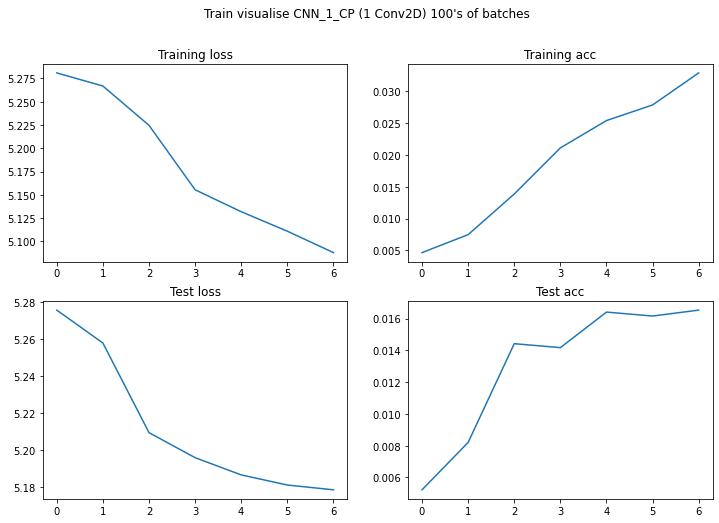

#### CNN_2_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.281354862090623 Acc: 0.005638636920813924
test Loss: 5.278312064195139 Acc: 0.005593536357986327

Epoch 1/6
----------
train Loss: 5.278422732539083 Acc: 0.00527089973032606
test Loss: 5.277590941671558 Acc: 0.008576755748912368

Epoch 2/6
----------
train Loss: 5.27716412185366 Acc: 0.008457955381220886
test Loss: 5.276428370952902 Acc: 0.008576755748912368

Epoch 3/6
----------
train Loss: 5.273992314821483 Acc: 0.008090218190733023
test Loss: 5.27609728065761 Acc: 0.00795525170913611

Epoch 4/6
----------
train Loss: 5.273315393799045 Acc: 0.008703113508212797
test Loss: 5.27574250296527 Acc: 0.007706650093225606

Epoch 5/6
----------
train Loss: 5.27253604221648 Acc: 0.008580534444716842
test Loss: 5.275348456473436 Acc: 0.008328154133001864

Epoch 6/6
----------
train Loss: 5.271648054995002 Acc: 0.008580534444716842
test Loss: 5.2753079448745 Acc: 0.008328154133001864



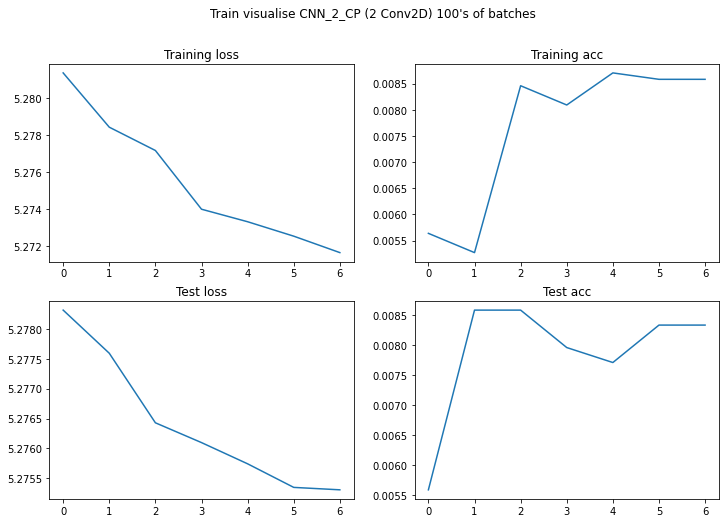

#### CNN_3_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.279033656914055 Acc: 0.004658004412846285
test Loss: 5.277835112524892 Acc: 0.008452454940957116

Epoch 1/6
----------
train Loss: 5.278059073890299 Acc: 0.008335376317724932
test Loss: 5.277210884734368 Acc: 0.008452454940957116

Epoch 2/6
----------
train Loss: 5.277373125109493 Acc: 0.008212797254228977
test Loss: 5.2764725955396505 Acc: 0.008452454940957116

Epoch 3/6
----------
train Loss: 5.275879238831935 Acc: 0.008335376317724932
test Loss: 5.276320488161001 Acc: 0.008452454940957116

Epoch 4/6
----------
train Loss: 5.27563699655423 Acc: 0.008335376317724932
test Loss: 5.276159381392285 Acc: 0.008452454940957116

Epoch 5/6
----------
train Loss: 5.275383938057336 Acc: 0.008335376317724932
test Loss: 5.275987974881681 Acc: 0.008452454940957116

Epoch 6/6
----------
train Loss: 5.275074689345606 Acc: 0.008335376317724932
test Loss: 5.27596964115975 Acc: 0.008452454940957116



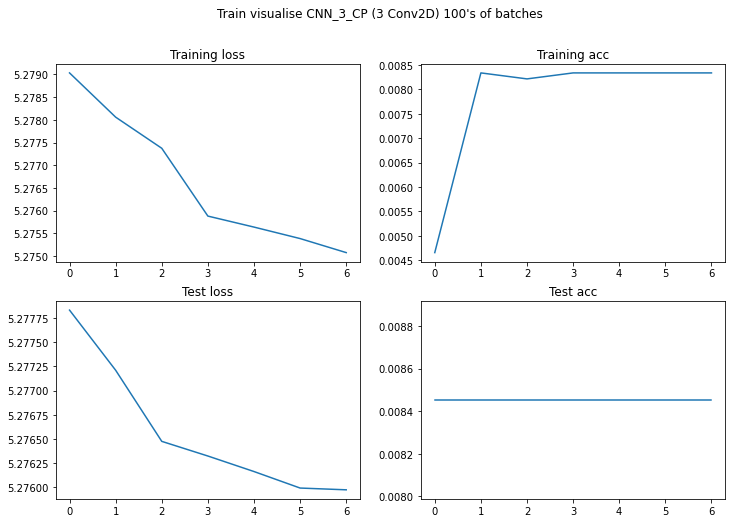

#### CNN_4_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.278497701650976 Acc: 0.00527089973032606
test Loss: 5.277996804300786 Acc: 0.00509633312616532

Epoch 1/6
----------
train Loss: 5.278191786941637 Acc: 0.00551605785731797
test Loss: 5.277754935127671 Acc: 0.005220633934120571

Epoch 2/6
----------
train Loss: 5.2779110935161615 Acc: 0.005393478793822014
test Loss: 5.277489908383158 Acc: 0.005966438781852082

Epoch 3/6
----------
train Loss: 5.2774892378215785 Acc: 0.0068644275557734735
test Loss: 5.277458260443138 Acc: 0.00584213797389683

Epoch 4/6
----------
train Loss: 5.277453201721333 Acc: 0.006006374111301789
test Loss: 5.2774266339000375 Acc: 0.006463642013673089

Epoch 5/6
----------
train Loss: 5.277416129415016 Acc: 0.006374111301789654
test Loss: 5.277394621856765 Acc: 0.006463642013673089

Epoch 6/6
----------
train Loss: 5.277366856319936 Acc: 0.005883795047805835
test Loss: 5.277391439761487 Acc: 0.006463642013673089



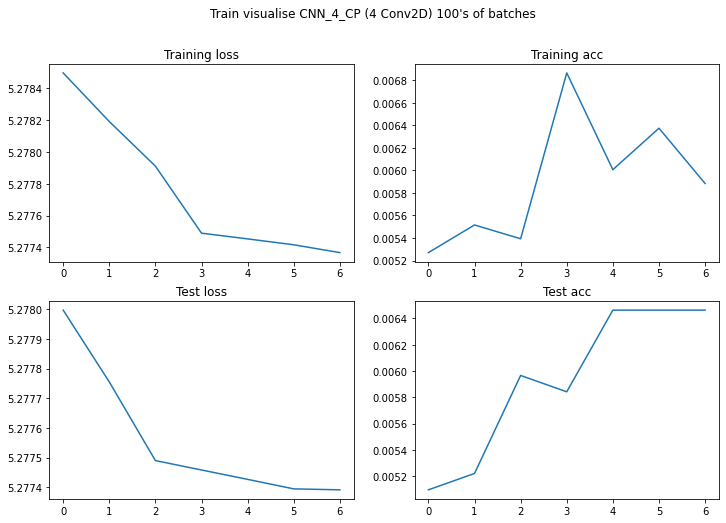

In [49]:
models = [net1, net2, net3, net4]
names = [f"CNN_{i+1}_CP" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Apply dropouts

In [69]:
class CNN_1_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear((
            10 * (((n_input - filters + 1) // 2))**2 ), 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net11 = CNN_1_CPD(input_n, 5)
print(net11)

CNN_1_CPD(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=392040, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [70]:
class CNN_2_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 20 , 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net22 = CNN_2_CPD(input_n, 5)
print(net22)

CNN_2_CPD(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=188180, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [71]:
class CNN_3_CPD(nn.Module):
    def __init__(self):
        super(CNN_3_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net33 = CNN_3_CPD(input_n, 5)
print(net33)

CNN_3_CPD(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=63480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [72]:
class CNN_4_CPD(nn.Module):
    def __init__(self, , n_input, filters):
        super(CNN_4_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(30, 40, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear( 40 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net44 = CNN_4_CPD(input_n, 5)
print(net44)

CNN_4_CPD(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=17640, out_features=200, bias=True)
  (fc2): Linea

#### CNN_1CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.292005268549563 Acc: 0.005393478793822014
test Loss: 5.278158302259712 Acc: 0.0053449347420758235

Epoch 1/6
----------
train Loss: 5.278711174013101 Acc: 0.004658004412846285
test Loss: 5.277997879896051 Acc: 0.0053449347420758235

Epoch 2/6
----------
train Loss: 5.277975959618847 Acc: 0.006128953174797744
test Loss: 5.277899176204627 Acc: 0.008452454940957116

Epoch 3/6
----------
train Loss: 5.277487471805656 Acc: 0.005761215984309879
test Loss: 5.277879303979014 Acc: 0.008452454940957116

Epoch 4/6
----------
train Loss: 5.277549004958055 Acc: 0.006374111301789654
test Loss: 5.277858952426851 Acc: 0.008328154133001864

Epoch 5/6
----------
train Loss: 5.277064072439909 Acc: 0.007354743809757293
test Loss: 5.2776202923174305 Acc: 0.008079552517091361

Epoch 6/6
----------
train Loss: 5.276902685799006 Acc: 0.006251532238293699
test Loss: 5.2775660066740935 Acc: 0.007706650093225606



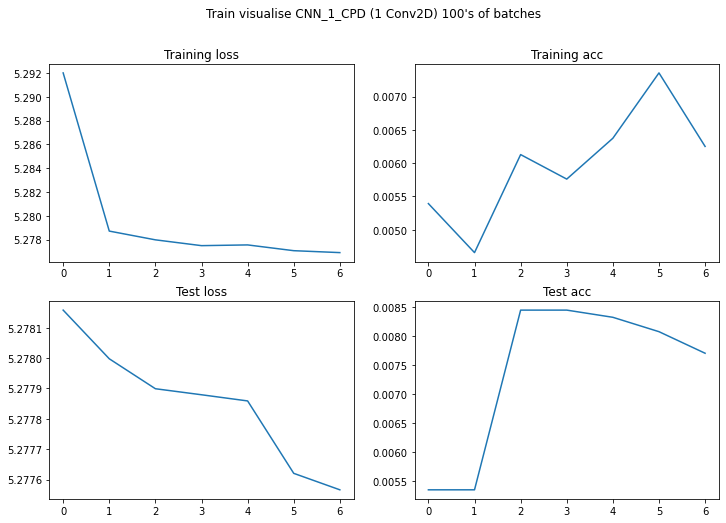

#### CNN_2CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.283765136567247 Acc: 0.00502574160333415
test Loss: 5.27855601764155 Acc: 0.005220633934120571

Epoch 1/6
----------
train Loss: 5.278259666856231 Acc: 0.005393478793822014
test Loss: 5.277410228508759 Acc: 0.005469235550031075

Epoch 2/6
----------
train Loss: 5.277510757918567 Acc: 0.006741848492277518
test Loss: 5.276143163238867 Acc: 0.006960845245494096

Epoch 3/6
----------
train Loss: 5.273866017620539 Acc: 0.006741848492277518
test Loss: 5.2756979614551796 Acc: 0.006960845245494096

Epoch 4/6
----------
train Loss: 5.272814562227773 Acc: 0.005883795047805835
test Loss: 5.274992728366698 Acc: 0.008203853325046613

Epoch 5/6
----------
train Loss: 5.272506845497156 Acc: 0.007967639127237067
test Loss: 5.274480888278978 Acc: 0.009073958980733375

Epoch 6/6
----------
train Loss: 5.27055054992167 Acc: 0.007967639127237067
test Loss: 5.274375875637796 Acc: 0.009198259788688627



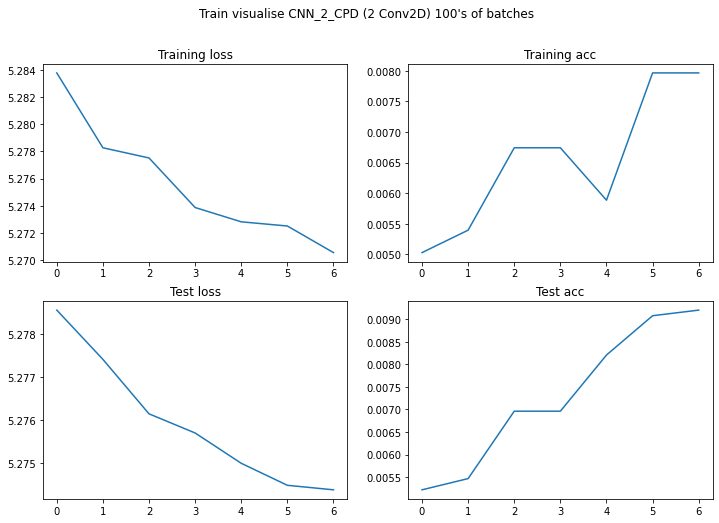

#### CNN_3CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.281234826665206 Acc: 0.004658004412846285
test Loss: 5.278366286299701 Acc: 0.00509633312616532

Epoch 1/6
----------
train Loss: 5.278551129039289 Acc: 0.0044128462858543755
test Loss: 5.277879506034685 Acc: 0.004972032318210068

Epoch 2/6
----------
train Loss: 5.277932443756717 Acc: 0.00502574160333415
test Loss: 5.277246867773176 Acc: 0.006836544437538844

Epoch 3/6
----------
train Loss: 5.277220056290193 Acc: 0.005393478793822014
test Loss: 5.277165989374952 Acc: 0.006960845245494096

Epoch 4/6
----------
train Loss: 5.276335324046365 Acc: 0.005761215984309879
test Loss: 5.277045956096567 Acc: 0.008576755748912368

Epoch 5/6
----------
train Loss: 5.275950078316605 Acc: 0.006128953174797744
test Loss: 5.276899967525522 Acc: 0.008203853325046613

Epoch 6/6
----------
train Loss: 5.2761387189073465 Acc: 0.006741848492277518
test Loss: 5.276884473133265 Acc: 0.008328154133001864



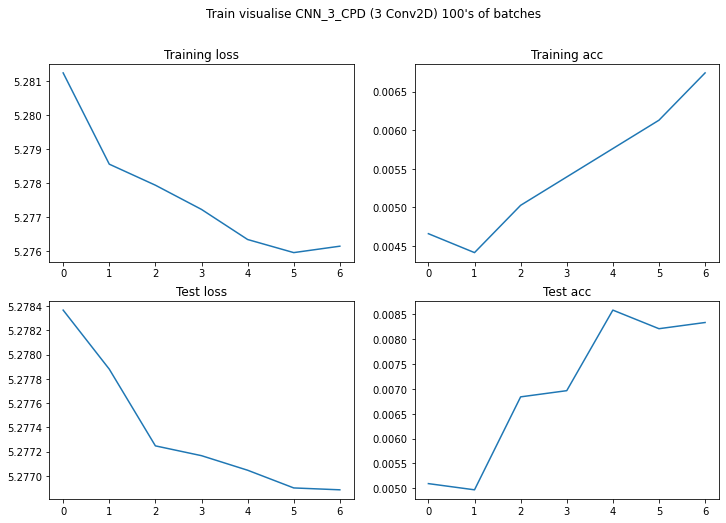

#### CNN_4CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.279056836530606 Acc: 0.005148320666830105
test Loss: 5.278632246862664 Acc: 0.004847731510254817

Epoch 1/6
----------
train Loss: 5.278804419700584 Acc: 0.005148320666830105
test Loss: 5.278333662103021 Acc: 0.004474829086389061

Epoch 2/6
----------
train Loss: 5.277970361721285 Acc: 0.006006374111301789
test Loss: 5.277883922690705 Acc: 0.0053449347420758235

Epoch 3/6
----------
train Loss: 5.277328676498238 Acc: 0.005148320666830105
test Loss: 5.277823030318882 Acc: 0.0053449347420758235

Epoch 4/6
----------
train Loss: 5.277508252390052 Acc: 0.005393478793822014
test Loss: 5.277764439153108 Acc: 0.004972032318210068

Epoch 5/6
----------
train Loss: 5.277048836797147 Acc: 0.006006374111301789
test Loss: 5.277687336748027 Acc: 0.0053449347420758235

Epoch 6/6
----------
train Loss: 5.277366030534771 Acc: 0.006374111301789654
test Loss: 5.277681810652862 Acc: 0.0053449347420758235



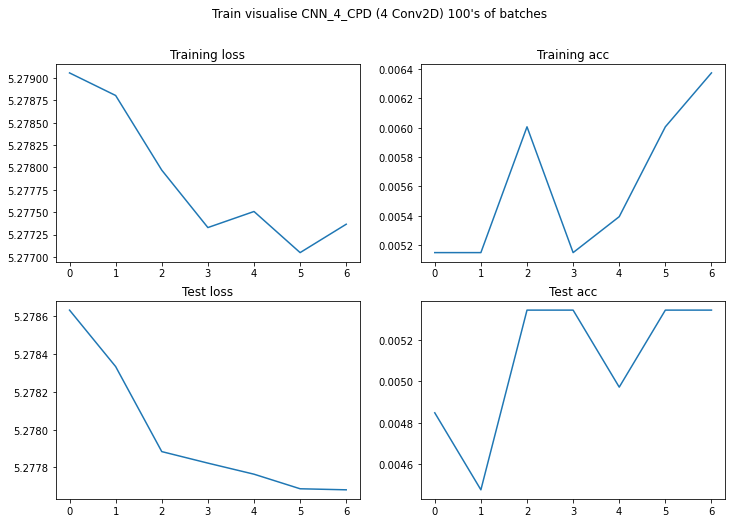

In [73]:
models = [net11, net22, net33, net44]
names = [f"CNN_{i+1}_CPD" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Add batch normalization

In [17]:
class CNN_1_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear((
            10 * (((n_input - filters + 1) // 2))**2 ), 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

        
net111 = CNN_1_CPDB(input_n, 5)
print(net111)

CNN_1_CPDB(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=392040, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [16]:
class CNN_2_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 20 , 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

        
net222 = CNN_2_CPDB(input_n, 5)
print(net222)

CNN_2_CPDB(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=188180, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [15]:
class CNN_3_CPDB(nn.Module):
    def __init__(self):
        super(CNN_3_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net333 = CNN_3_CPDB(input_n, 5)
print(net333)

CNN_3_CPDB(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (fc1): Linear(in_features=63480, out

In [14]:
class CNN_4_CPDB(nn.Module):
    def __init__(self, , n_input, filters):
        super(CNN_4_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 15, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(15, 25, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(25, 35, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(35),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(35, 45, filters),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(45),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear( 45 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net444 = CNN_4_CPDB(input_n, 5)
print(net444)

CNN_4_CPDB(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2

#### CNN_1CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.280644154951951 Acc: 0.00551605785731797
test Loss: 5.2787735623702865 Acc: 0.005717837165941578

Epoch 1/6
----------
train Loss: 5.279133613859505 Acc: 0.0064966903652856085
test Loss: 5.278617656593963 Acc: 0.005717837165941578

Epoch 2/6
----------
train Loss: 5.278717398146666 Acc: 0.006128953174797744
test Loss: 5.278417915050253 Acc: 0.005717837165941578

Epoch 3/6
----------
train Loss: 5.276643351147823 Acc: 0.006741848492277518
test Loss: 5.278180052672505 Acc: 0.005717837165941578

Epoch 4/6
----------
train Loss: 5.275858508865458 Acc: 0.006251532238293699
test Loss: 5.2773407581654155 Acc: 0.006215040397762586

Epoch 5/6
----------
train Loss: 5.2757292144524754 Acc: 0.006374111301789654
test Loss: 5.2773472371643715 Acc: 0.006215040397762586

Epoch 6/6
----------
train Loss: 5.275961695421148 Acc: 0.006741848492277518
test Loss: 5.277205975237954 Acc: 0.006090739589807334



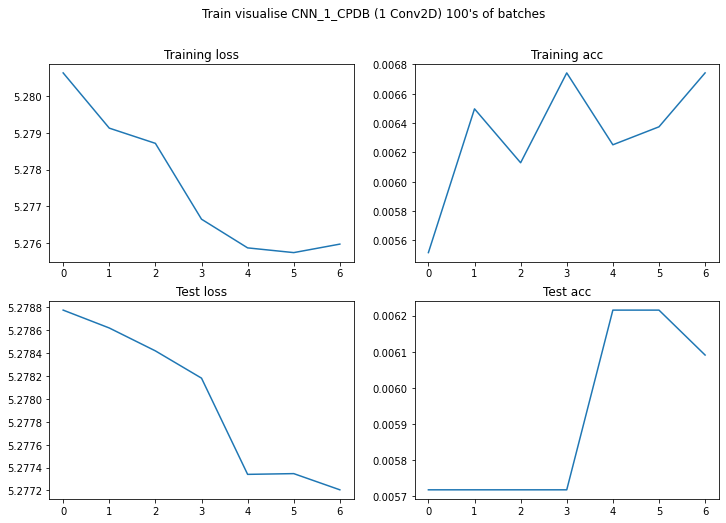

#### CNN_2CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.301032508696724 Acc: 0.004658004412846285
test Loss: 5.278294777203377 Acc: 0.00584213797389683

Epoch 1/6
----------
train Loss: 5.2780956567342034 Acc: 0.005638636920813924
test Loss: 5.277489804954837 Acc: 0.005966438781852082

Epoch 2/6
----------
train Loss: 5.277852434245767 Acc: 0.005638636920813924
test Loss: 5.277957926158064 Acc: 0.0053449347420758235

Epoch 3/6
----------
train Loss: 5.275644760851943 Acc: 0.006619269428781564
test Loss: 5.2779644591531225 Acc: 0.005469235550031075

Epoch 4/6
----------
train Loss: 5.2752565124158215 Acc: 0.005883795047805835
test Loss: 5.277945717882117 Acc: 0.004972032318210068

Epoch 5/6
----------
train Loss: 5.272685428903687 Acc: 0.008090218190733023
test Loss: 5.277685828413409 Acc: 0.004972032318210068

Epoch 6/6
----------
train Loss: 5.271245988100935 Acc: 0.006374111301789654
test Loss: 5.277665517639862 Acc: 0.004972032318210068



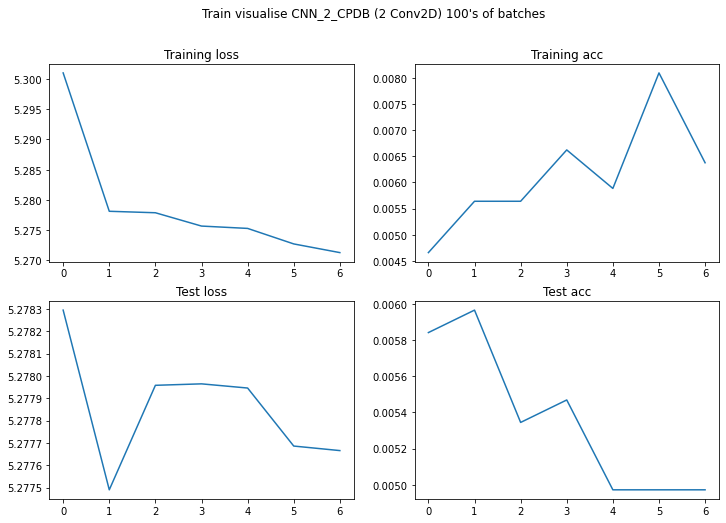

#### CNN_3CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.297464065734123 Acc: 0.006251532238293699
test Loss: 5.277413069735113 Acc: 0.004599129894344313

Epoch 1/6
----------
train Loss: 5.271940076313173 Acc: 0.006006374111301789
test Loss: 5.271160208356536 Acc: 0.00658794282162834

Epoch 2/6
----------
train Loss: 5.256942058842858 Acc: 0.009070850698700662
test Loss: 5.260308254068871 Acc: 0.008079552517091361

Epoch 3/6
----------
train Loss: 5.21279388387053 Acc: 0.013483696984555036
test Loss: 5.2556146167686375 Acc: 0.00870105655686762

Epoch 4/6
----------
train Loss: 5.196334965470434 Acc: 0.01483206668301054
test Loss: 5.250956349227649 Acc: 0.009198259788688627

Epoch 5/6
----------
train Loss: 5.180682313591278 Acc: 0.016303015444962
test Loss: 5.248096659407251 Acc: 0.010316967060285892

Epoch 6/6
----------
train Loss: 5.1659358688124435 Acc: 0.017406227016425593
test Loss: 5.247543130000976 Acc: 0.010316967060285892



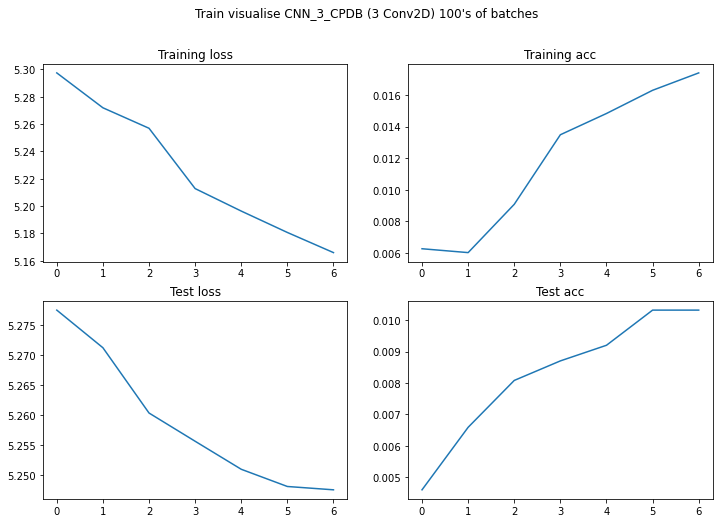

#### CNN_4CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.296853585697968 Acc: 0.005638636920813924
test Loss: 5.277789845179148 Acc: 0.007209446861404599

Epoch 1/6
----------
train Loss: 5.276721187361493 Acc: 0.006374111301789654
test Loss: 5.275912996995071 Acc: 0.005717837165941578

Epoch 2/6
----------
train Loss: 5.265961647968895 Acc: 0.006251532238293699
test Loss: 5.272060831293992 Acc: 0.007209446861404599

Epoch 3/6
----------
train Loss: 5.244317107704464 Acc: 0.010419220397156165
test Loss: 5.270642397698592 Acc: 0.00795525170913611

Epoch 4/6
----------
train Loss: 5.242360124987813 Acc: 0.009561166952684481
test Loss: 5.268719260213981 Acc: 0.008328154133001864

Epoch 5/6
----------
train Loss: 5.23276489276049 Acc: 0.012625643540083352
test Loss: 5.267313403502394 Acc: 0.008079552517091361

Epoch 6/6
----------
train Loss: 5.229496271886729 Acc: 0.01360627604805099
test Loss: 5.267326982188773 Acc: 0.007706650093225606



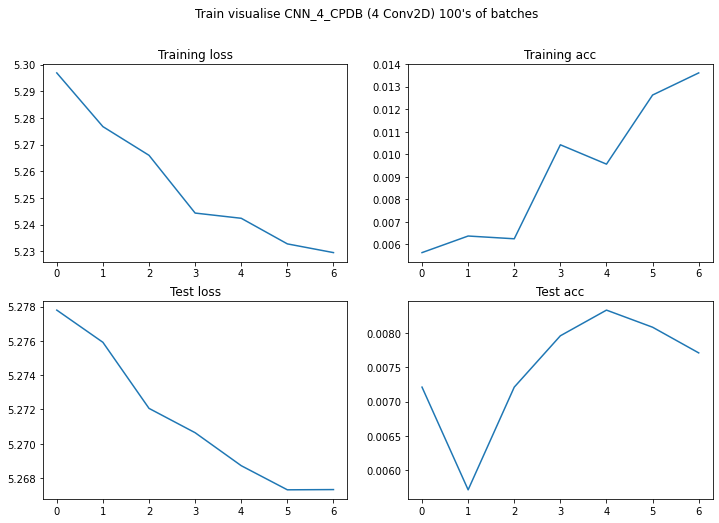

In [18]:
models = [net111, net222, net333, net444]
names = [f"CNN_{i+1}_CPDB" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Added image augmentation

In [12]:
data_transforms = {
    "train": transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor(),
                                ]),
    "test": transforms.Compose([transforms.Resize((400, 400)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                ])
}
    

image_datasets = {x: datasets.ImageFolder(root=os.path.join(dataset_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == "train" else False, num_workers=6)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Visualize dataset

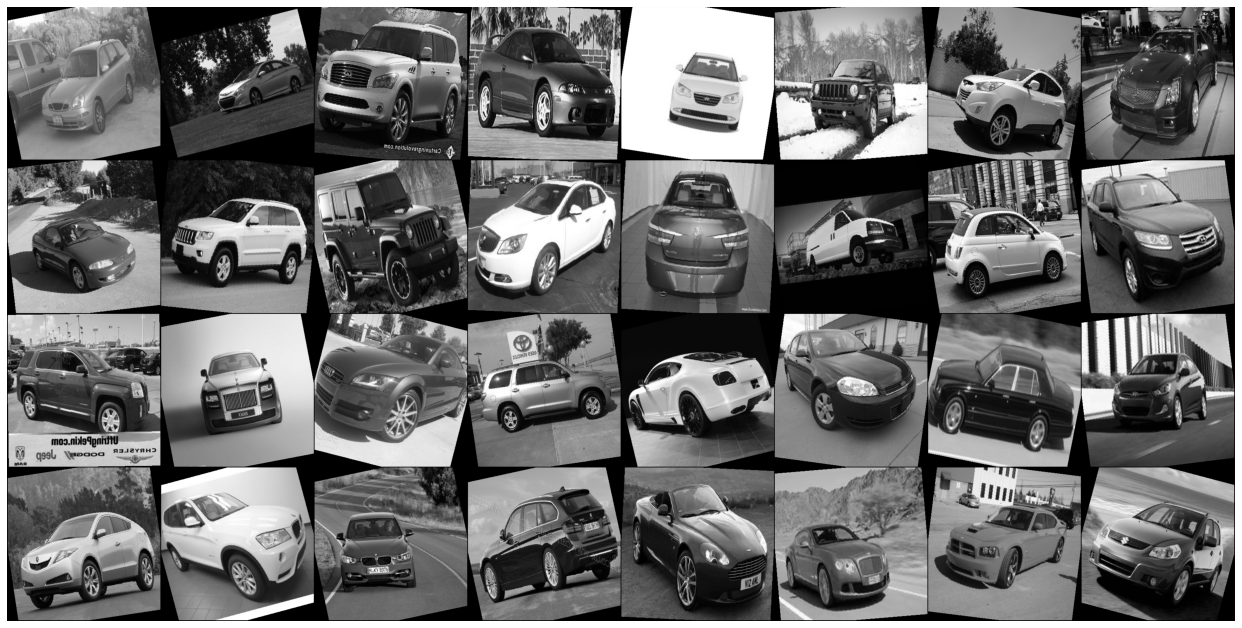

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### CNN_1CPDB with image augmentation. Baseline ####
Epoch 0/6
----------
train Loss: 5.305531578106049 Acc: 0.0044128462858543755
test Loss: 5.279107669157001 Acc: 0.005469235550031075

Epoch 1/6
----------
train Loss: 5.279946809657855 Acc: 0.005393478793822014
test Loss: 5.278952402739587 Acc: 0.005593536357986327

Epoch 2/6
----------
train Loss: 5.279542733361015 Acc: 0.004535425349350331
test Loss: 5.278694153958185 Acc: 0.005469235550031075

Epoch 3/6
----------
train Loss: 5.278802779352703 Acc: 0.00551605785731797
test Loss: 5.278726664946789 Acc: 0.005469235550031075

Epoch 4/6
----------
train Loss: 5.279288350732106 Acc: 0.005393478793822014
test Loss: 5.278632377852113 Acc: 0.005469235550031075

Epoch 5/6
----------
train Loss: 5.279004582121957 Acc: 0.00527089973032606
test Loss: 5.2786860612403395 Acc: 0.005469235550031075

Epoch 6/6
----------
train Loss: 5.27889664461286 Acc: 0.00551605785731797
test Loss: 5.27868540617455 Acc: 0.005469235550031075



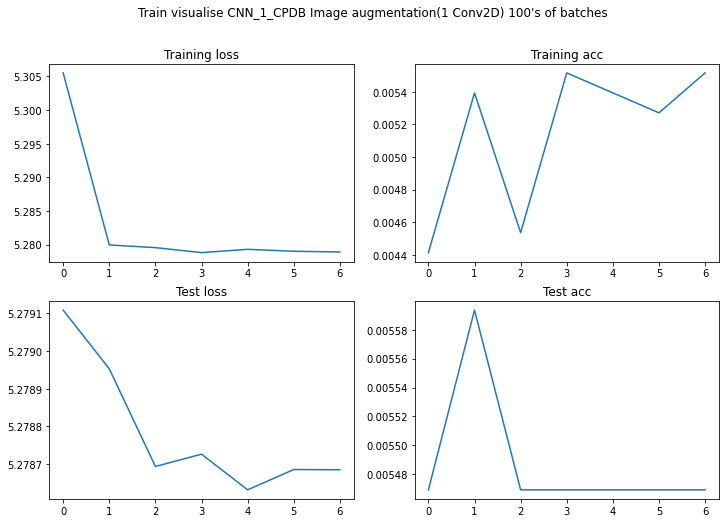

#### CNN_2CPDB with image augmentation. Baseline ####
Epoch 0/6
----------
train Loss: 5.299707763771941 Acc: 0.00551605785731797
test Loss: 5.2793499889693845 Acc: 0.00509633312616532

Epoch 1/6
----------
train Loss: 5.281165796449646 Acc: 0.00551605785731797
test Loss: 5.27949575225043 Acc: 0.005593536357986327

Epoch 2/6
----------
train Loss: 5.279015746938449 Acc: 0.004658004412846285
test Loss: 5.278620918823963 Acc: 0.00435052827843381

Epoch 3/6
----------
train Loss: 5.27903894502528 Acc: 0.0047805834763422405


KeyboardInterrupt: 

In [21]:
models = [net111, net222, net333, net444]
learning_rate = 0.001

for i in range(len(models)):
    print(f'#### CNN_{i+1}CPDB with image augmentation. Baseline ####')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i],
                                            criterion,
                                            optimizer,
                                            lrscheduler,
                                            n_epochs=7)
    
    visual(training_losses,
           training_accs,
           test_losses,
           test_accs,
           f'CNN_{i+1}_CPDB Image augmentation({i+1} Conv2D)')
    
    #Save model
    model_dir = 'saved_models/'
    model_name = f'CNN_{i+1}CPDB_Image_augmentation.pt'
    torch.save(model_ft.state_dict(), model_dir+model_name)